In [1]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from tensorflow.python.client import device_lib

print('Tensorflow version ' + tf.__version__)
device_lib.list_local_devices()

Tensorflow version 2.10.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6403149021780519220
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6235881472
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8874909230384729154
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:08:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
# pixel labels in the video frames
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'bicyclist', 'void']

In [3]:
train_image_path = '../Dataset/images_prepped_train/'
train_label_path = '../Dataset/annotations_prepped_train/'
test_image_path = '../Dataset/images_prepped_test/'
test_label_path = '../Dataset/annotations_prepped_test/'
 
BATCH_SIZE = 8

In [4]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=256, width=256):
 
    # Convert image and mask files to tensors
    img_raw = tf.io.read_file(t_filename)
    anno_raw = tf.io.read_file(a_filename)
    image = tf.image.decode_jpeg(img_raw)
    annotation = tf.image.decode_jpeg(anno_raw)
 
    # Resize image and segmentation mask
    image = tf.image.resize(image, (height, width,))
    annotation = tf.image.resize(annotation, (height, width,))
    image = tf.reshape(image, (height, width, 3,))
    annotation = tf.cast(annotation, dtype=tf.int32)
    annotation = tf.reshape(annotation, (height, width, 1,))
    stack_list = []
 
    # Reshape segmentation masks
    for c in range(len(class_names)):
        mask = tf.equal(annotation[:,:,0], tf.constant(c))
        stack_list.append(tf.cast(mask, dtype=tf.int32))
    
    annotation = tf.stack(stack_list, axis=2)
 
    # Normalize pixels in the input image
    image = image / 127.5
    image -= 1
 
    return image, annotation
 
def get_dataset_slice_paths(image_dir, label_map_dir):
 
    image_file_list = os.listdir(image_dir)
    label_map_file_list = os.listdir(label_map_dir)
    image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
    label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]
 
    return image_paths, label_map_paths
 
def get_training_dataset(image_paths, label_map_paths):

    training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
    training_dataset = training_dataset.map(map_filename_to_image_and_mask)
    training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
    training_dataset = training_dataset.batch(BATCH_SIZE)
    training_dataset = training_dataset.repeat()
    training_dataset = training_dataset.prefetch(-1)
 
    return training_dataset
 
def get_validation_dataset(image_paths, label_map_paths):
   
    validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
    validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.repeat()
 
    return validation_dataset

In [5]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths(train_image_path, train_label_path)
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths(test_image_path, test_label_path)
# generate the train and valid sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

In [6]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))
 
for class_name, color in zip(class_names, colors):
    print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
bicyclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [7]:
# Visualization Utilities
 
def fuse_with_pil(images):
 
    widths = (image.shape[1] for image in images)
    heights = (image.shape[0] for image in images)
    total_width = sum(widths)
    max_height = max(heights)
 
    new_im = PIL.Image.new('RGB', (total_width, max_height))
 
    x_offset = 0
    for im in images:
        pil_image = PIL.Image.fromarray(np.uint8(im))
        new_im.paste(pil_image, (x_offset,0))
        x_offset += im.shape[1]
  
    return new_im
 
 
def give_color_to_annotation(annotation):
    seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
    for c in range(12):
        segc = (annotation == c)
        seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
        seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
        seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
    return seg_img
 
 
def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
 
    true_img = give_color_to_annotation(labelmaps[1])
    pred_img = give_color_to_annotation(labelmaps[0])
 
    image = image + 1
    image = image * 127.5
    images = np.uint8([image, pred_img, true_img])
 
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
    display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list) 
 
    plt.figure(figsize=(15, 4))
 
    for idx, im in enumerate(images):
        plt.subplot(1, 3, idx+1)
        if idx == 1:
            plt.xlabel(display_string)
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[idx], fontsize=12)
        plt.imshow(im)
 
 
def show_annotation_and_image(image, annotation):
    new_ann = np.argmax(annotation, axis=2)
    seg_img = give_color_to_annotation(new_ann)
  
    image = image + 1
    image = image * 127.5
    image = np.uint8(image)
    images = [image, seg_img]
    fused_img = fuse_with_pil(images)
    plt.imshow(fused_img)
 
 
def list_show_annotation(dataset):
 
    ds = dataset.unbatch()
    ds = ds.shuffle(buffer_size=100)
 
    plt.figure(figsize=(25, 15))
    plt.title("Images And Annotations")
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)
 
    # we set the number of image-annotation pairs to 9
    # feel free to make this a function parameter if you want
    for idx, (image, annotation) in enumerate(ds.take(9)):
        plt.subplot(3, 3, idx + 1)
        plt.yticks([])
        plt.xticks([])
        show_annotation_and_image(image.numpy(), annotation.numpy())

C:\Users\wndyd\AppData\Local\Temp\ipykernel_9120\1296731190.py:86: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, idx + 1)


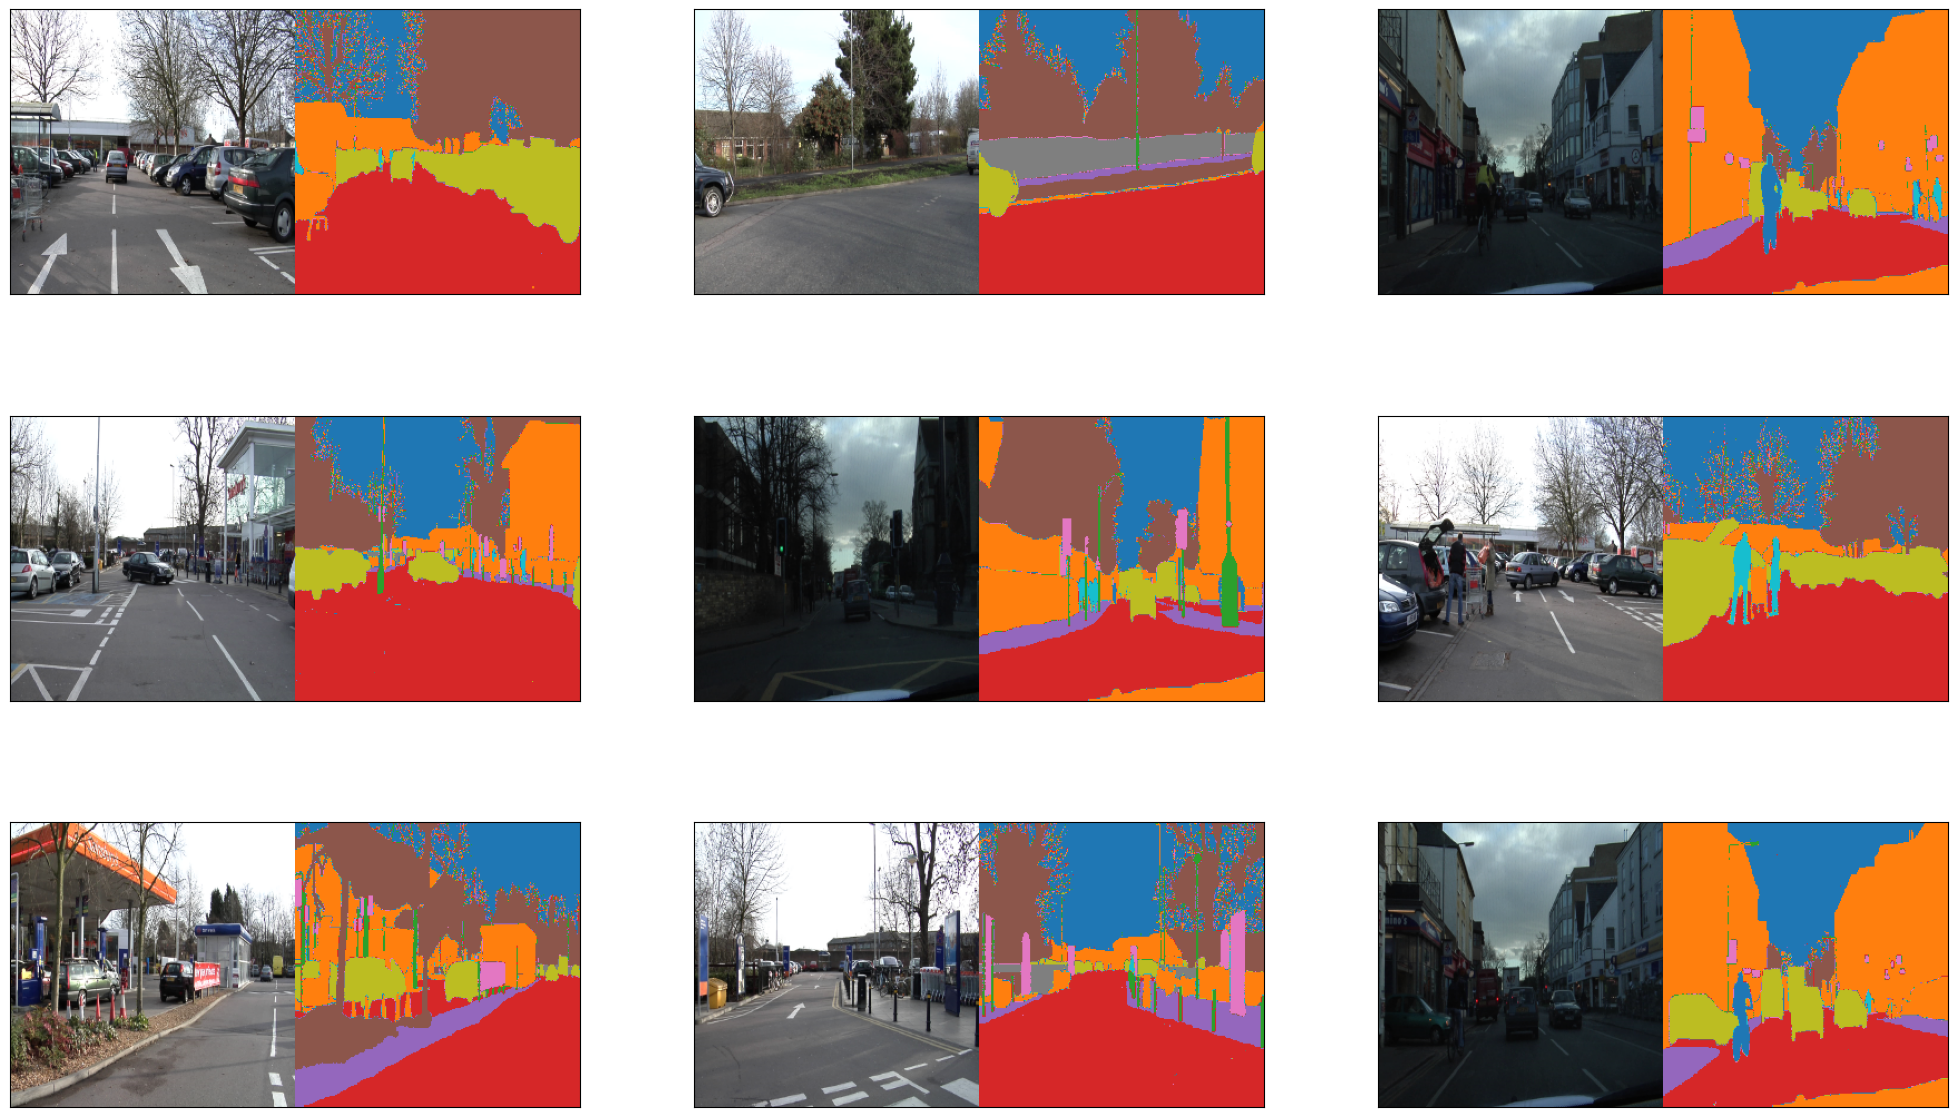

In [8]:
list_show_annotation(training_dataset)

In [9]:
# number of training images
train_count = len(training_image_paths)
# number of validation images
valid_count = len(validation_image_paths)

steps_per_epoch = train_count//BATCH_SIZE
validation_steps = valid_count//BATCH_SIZE

print(train_count, valid_count)

367 101


In [53]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
inputs = Input((256,256,3),name='input_1')
encoder = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)
encoder.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [10]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

print("TF Version: ", tf.__version__)

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_effienet_unet(input_shape):
    """ Input """
    inputs = Input(input_shape,name='input_1')

    """ Pre-trained Encoder """
    encoder = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = encoder.get_layer("input_1").output                      ## 256 특성맵
    s2 = encoder.get_layer("block2a_expand_activation").output    ## 128
    s3 = encoder.get_layer("block3a_expand_activation").output    ## 64
    s4 = encoder.get_layer("block4a_expand_activation").output    ## 32

    """ Bottleneck """
    b1 = encoder.get_layer("block6a_expand_activation").output    ## 16

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                               ## 32
    d2 = decoder_block(d1, s3, 256)                               ## 64
    d3 = decoder_block(d2, s2, 128)                               ## 128
    d4 = decoder_block(d3, s1, 64)                                ## 256

    """ Output """
    outputs = Conv2D(12, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="EfficientNetB0_UNET")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_effienet_unet(input_shape)
    model.summary()

TF Version:  2.10.0
Model: "EfficientNetB0_UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0      

In [12]:
from tensorflow.keras.losses import BinaryCrossentropy

# 이진 교차 엔트로피 손실 함수
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = BinaryCrossentropy() # CategoricalCrossentropy
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [40]:
with tf.device('/device:GPU:0'):
    history_unet = model.fit(training_dataset,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=validation_dataset,
                                    validation_steps=validation_steps,
                                    epochs=100)

Epoch 1/100


45/45 [==============================] - 11s 228ms/step - loss: 0.0157 - accuracy: 0.9655 - val_loss: 0.0694 - val_accuracy: 0.8800
Epoch 2/100
45/45 [==============================] - 10s 229ms/step - loss: 0.0156 - accuracy: 0.9657 - val_loss: 0.0724 - val_accuracy: 0.8721
Epoch 3/100
45/45 [==============================] - 10s 227ms/step - loss: 0.0154 - accuracy: 0.9659 - val_loss: 0.0713 - val_accuracy: 0.8796
Epoch 4/100
45/45 [==============================] - 10s 227ms/step - loss: 0.0153 - accuracy: 0.9661 - val_loss: 0.0697 - val_accuracy: 0.8813
Epoch 5/100
45/45 [==============================] - 10s 227ms/step - loss: 0.0151 - accuracy: 0.9665 - val_loss: 0.0965 - val_accuracy: 0.8429
Epoch 6/100
45/45 [==============================] - 10s 230ms/step - loss: 0.0151 - accuracy: 0.9666 - val_loss: 0.0649 - val_accuracy: 0.8901
Epoch 7/100
45/45 [==============================] - 10s 229ms/step - loss: 0.0154 - accuracy: 0.9658 - val_loss: 0.0781 - val_accuracy: 0.8721
Epoc

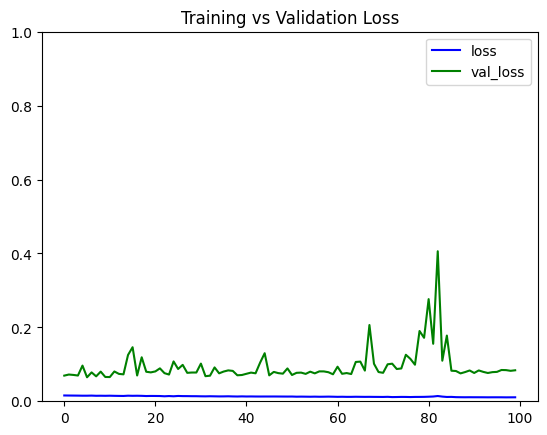

In [46]:
def plot_metrics(model_history, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(model_history.history[metric_name], 'b', label=metric_name)
    plt.plot(model_history.history['val_' + metric_name], 'g', label='val_'+metric_name)
    plt.legend()
    
plot_metrics(history_unet, "loss", title="Training vs Validation Loss", ylim=1)

In [47]:
def get_images_and_segments_test_arrays():
    y_true_segments = []
    y_true_images = []
    test_count = 64
    
    ds = validation_dataset.unbatch()
    ds = ds.batch(101)
    
    for image, annotation in ds.take(1):
        y_true_images = image
        y_true_segments = annotation
    
    y_true_segments = y_true_segments[:test_count,:,:,:]
    y_true_segments = np.argmax(y_true_segments, axis=3)
    
    return y_true_images, y_true_segments

y_true_images, y_true_segments = get_images_and_segments_test_arrays()

In [48]:
result_unet = model.predict(validation_dataset, steps=validation_steps)
results_unet = np.argmax(result_unet, axis=3)

12/12 [==============================] - 1s 77ms/step


In [49]:
def compute_metrics(y_true, y_pred) :
    class_wise_iou = []
    class_wise_dice_score = []
    
    smoothening_factor = 0.00001
    
    for i in range(12):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area
 
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)
 
        dice_score = 2*((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)
 
    return class_wise_iou, class_wise_dice_score
    

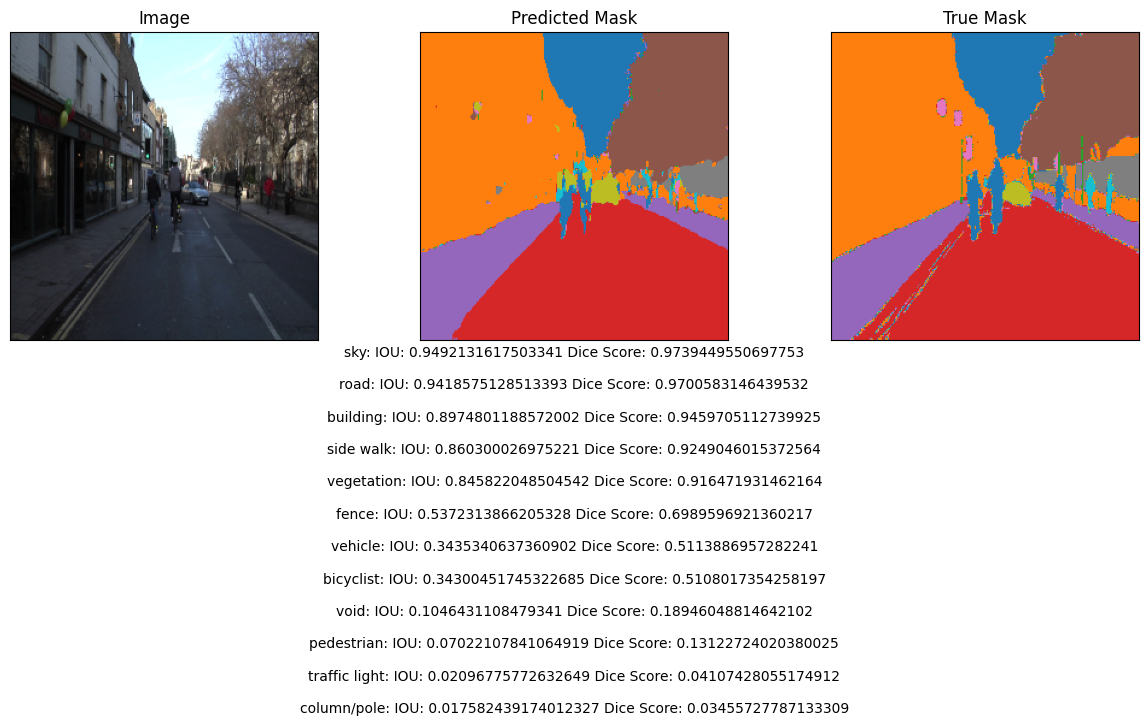

In [50]:
integer_slider = 10
iou_fcn32, dice_score_fcn32 = compute_metrics(y_true_segments[integer_slider], results_unet[integer_slider])
show_predictions(y_true_images[integer_slider], [results_unet[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou_fcn32, dice_score_fcn32)